# Read csv downloaded from NASCOP  to summarize it for DATIM and for our consumption:

In [1]:
%%time
# import pandas
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import calendar

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# plt.style.use('fivethirtyeight')
import seaborn as sns
from io import StringIO
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)

from collections import defaultdict
from IPython.display import display
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# read dataframe from the directory
# df=pd.read_csv('UON CRISSP EID TEST OUTCOMES FOR  IN 01OCT2020  31DEC2020.csv',index_col=None)
df=pd.read_csv('UON CRISSP EID TEST OUTCOMES FOR  IN 01OCT2020  16SEP2021.csv',index_col=None)
# df=df[df['County']=="Kiambu"]
df=df[df['County']=="Kirinyaga"]
# df=df[df['Sub-County']=="Kirinyaga Central"]
# df=df[df['Sub-County']=="Kirinyaga East"]
# df=df[df['Sub-County']=="Kirinyaga North"]
# df=df[df['Sub-County']=="Kirinyaga South"]
# df=df[df['Sub-County']=="Kirinyaga North/Mwea West"]

Wall time: 9.98 s


In [2]:
from IPython.display import HTML
,
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
''')

In [3]:
def get_results(df):
    """Displays answer in form of a """  
    
    # get unique values in 'PCR type' column
    pcr_types=[] # store unique value from above in a list
    for pcr_type in df['PCR Type']: 
        df=df[df['PCR Type']==pcr_type]
        pcr_types.append(pcr_type)
        
    # count values in the pcr type list
    results = defaultdict(int)
    for pcr_type in pcr_types:
        results[pcr_type] += 1 
        
    #convert dictionary to a dataframe       
    num=pd.DataFrame(results.items(),columns=['PCR type','Count'],index=None )
    
    return num   

In [4]:
def age_buckets(x):
    """convert age to age ranges"""
    if x == 2: 
        return '< 2' 
    elif x == 12: 
        return '2-12' 

#####  PMTCT_EID Disaggregated by Infant Test Results
use table below to fill DATIM report

In [5]:
# change df to datim
summary_PCR_done=df

# Replace <2 with 2 and 2-12 with 12
summary_PCR_done.loc[summary_PCR_done['Age (Months)'] < 2, 'Age (Months)'] = 2
summary_PCR_done.loc[(summary_PCR_done['Age (Months)'] >2) & (summary_PCR_done['Age (Months)'] <12), 'Age (Months)'] = 12

# Filter all rows for which the children age is greater than >12. Not need in the report
summary_PCR_done.drop(summary_PCR_done[summary_PCR_done['Age (Months)'] > 12].index, inplace = True)
summary_PCR_done=summary_PCR_done[summary_PCR_done['PCR Type'] != 'Confirmatory PCR and Baseline VL']
# summary_PCR_done

In [6]:
# add a column of count to the dataframe
summary_PCR_done=summary_PCR_done.copy()
summary_PCR_done['Counts']=1

summary_PCR_done['Age'] = summary_PCR_done['Age (Months)'].apply(age_buckets)

# group dataframe by Facilty',"Result" and'Age (Months)'
facilities=summary_PCR_done.groupby(['County','Facilty','Result','Age']).sum()['Counts'].reset_index()
# facilities
# ages

# #convert summary into a dataframe 
# pd.DataFrame(summary_PCR_done,columns=['Count'])

In [7]:
df2=summary_PCR_done.groupby(["Sub-County",'Result','Age']).sum()['Counts'].reset_index()
subcounties=df2.pivot_table(index=['Sub-County', 'Age'], columns="Result").reset_index()

In [8]:
def convert_pivot_to_dataframe(subcounties):
    """convert pivot table to dataframe"""  
    subcounties.columns = subcounties.columns.droplevel(0) #remove amount
    subcounties = subcounties.reset_index()                #index to columns
    return subcounties
    
# subcounties

In [9]:
subcounties=convert_pivot_to_dataframe(subcounties)

subcounties.columns=["index","Sub-Counties","Months Initial PCR done","Negative","Positive"]
del subcounties['index']
subcounties=subcounties.fillna(0)
subcounties["Total"]=subcounties["Negative"]+subcounties["Positive"]
pcr_done=subcounties['Total'].sum().astype(int)
positive_sample=subcounties['Positive'].sum().astype(int)
negative_sample=subcounties['Negative'].sum().astype(int)
subcounties['Total']=subcounties['Total'].astype(int)
subcounties['Positive']=subcounties['Positive'].astype(int)
subcounties['Negative']=subcounties['Negative'].astype(int)
subcounties

,Sub-Counties,Months Initial PCR done,Negative,Positive,Total
0,Kirinyaga Central,2-12,119,0,119
1,Kirinyaga Central,< 2,78,2,80
2,Kirinyaga East,2-12,30,0,30
3,Kirinyaga East,< 2,18,1,19
4,Kirinyaga North,2-12,59,0,59
5,Kirinyaga North,< 2,28,2,30
6,Kirinyaga North/Mwea West,2-12,73,2,75
7,Kirinyaga North/Mwea West,< 2,33,0,33
8,Kirinyaga South,2-12,142,0,142
9,Kirinyaga South,< 2,63,0,63


In [10]:
negative=subcounties.groupby("Sub-Counties").sum()['Negative'].reset_index()
positives=subcounties.groupby("Sub-Counties").sum()[['Positive','Negative']].reset_index().sort_values("Negative")
positives['Total']=positives['Positive']+positives['Negative']


positives['Total']=positives['Total'].astype(int)
positives['Positive']=positives['Positive'].astype(int)
positives['Negative']=positives['Negative'].astype(int)
positives['mtct rate']=round(positives['Positive']/positives['Total']*100,1)
positives

,Sub-Counties,Positive,Negative,Total,mtct rate
1,Kirinyaga East,1,48,49,2.0
2,Kirinyaga North,2,87,89,2.2
3,Kirinyaga North/Mwea West,2,106,108,1.9
0,Kirinyaga Central,2,197,199,1.0
4,Kirinyaga South,0,205,205,0.0


In [11]:
positives

,Sub-Counties,Positive,Negative,Total,mtct rate
1,Kirinyaga East,1,48,49,2.0
2,Kirinyaga North,2,87,89,2.2
3,Kirinyaga North/Mwea West,2,106,108,1.9
0,Kirinyaga Central,2,197,199,1.0
4,Kirinyaga South,0,205,205,0.0


In [12]:

# positives=positives.sort_values('TX_CURR')
positives
# fig=px.bar(positives,x='Sub-Counties',y=['tx curr target','Negative ','Positive'],title=F"TX CURR BY SUB-COUNTIES N={total_curr}"
#            f"    Positive: {Positive}  Negative : {Negative }",hover_data=['tx curr target','TX_CURR','Sub-Counties','achievement %'],
#            labels={'tx curr target':'TX_CURR TARGET','TX_CURR':'Current TX_CURR'},barmode='group')

# texts=[positives['Negative '],positives['Positive']]
# for i, t in enumerate(texts):
#     fig.data[i].text = t
#     fig.data[i].textposition = 'outside'
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(x=positives['Sub-Counties'],
           y=positives['Negative'], name="Negative", text=positives['Negative'], textposition='outside'),
    secondary_y=False,
)
fig.add_trace(
go.Bar(x=positives['Sub-Counties'],
       y=positives['Positive'], name="Positive", text=positives['Positive'], textposition='outside'),
secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=positives['Sub-Counties'],
               y=positives['mtct rate'], name="mtct rate %", text=positives['mtct rate'], textposition='top center', mode="lines+markers+text",
              textfont_size=18,textfont=dict(
                                                family="sans serif",
                                                size=22,
                                                color="RED")),
    secondary_y=True,
)


# Add figure title
fig.update_layout(
    title_text=f"<b>Number of PCR done per Sub-county N= {pcr_done} Positive: {positive_sample}  Negative : {negative_sample }<b>"
)

# Set x-axis title
fig.update_xaxes(title_text="<b>SUB-COUNTIES<b>")

# Set y-axes titles
fig.update_yaxes(title_text="<b>PCR DONE</b> ", secondary_y=False)
fig.update_yaxes(title_text="<b>mtct rate</b>", secondary_y=True)

fig.show()

In [13]:
facilities=facilities.pivot_table(index=["County",'Facilty', 'Age'], columns="Result").reset_index()

facilities=convert_pivot_to_dataframe(facilities)

facilities.columns=["index","County","Facility","Months Initial PCR done","Negative","Positive"]
del facilities['index']
facilities=facilities.fillna(0)
facilities["Total PCRs done"]=facilities["Negative"]+facilities["Positive"]

facilities["Total PCRs done"]=facilities["Total PCRs done"].astype(int)
facilities["Positive"]=facilities["Positive"].astype(int)
facilities["Negative"]=facilities["Negative"].astype(int)
facilities

,County,Facility,Months Initial PCR done,Negative,Positive,Total PCRs done
0,Kirinyaga,Baricho Health Centre,2-12,16,1,17
1,Kirinyaga,Baricho Health Centre,< 2,7,0,7
2,Kirinyaga,Difathas Health Centre,2-12,13,0,13
3,Kirinyaga,Difathas Health Centre,< 2,9,0,9
4,Kirinyaga,Gathambi Dispensary,2-12,4,0,4
5,Kirinyaga,Gathambi Dispensary,< 2,3,0,3
6,Kirinyaga,Gathigiriri Dispensary,2-12,7,0,7
7,Kirinyaga,Gathigiriri Dispensary,< 2,5,0,5
8,Kirinyaga,Gatwe Dispensary,< 2,3,0,3
9,Kirinyaga,Kabare Health Centre,2-12,6,0,6


In [14]:
facilities_pos=facilities[facilities['Positive']!=0]

facilities_pos=facilities_pos.copy()
facilities_pos['facilities'] = facilities_pos['Facility'].str.split().str[0]
del facilities_pos['Facility']

sorted_columns=['County', 'facilities','Months Initial PCR done', 'Negative', 'Positive',
       'Total PCRs done']

facilities_pos = facilities_pos.reindex(sorted_columns, axis=1)
facilities_pos=facilities_pos.groupby(['facilities','Months Initial PCR done']).sum()['Positive'].reset_index()
facilities_pos=facilities_pos.sort_values("Positive")
facilities_pos=facilities_pos.pivot(index="facilities",columns="Months Initial PCR done")
facilities_pos=convert_pivot_to_dataframe(facilities_pos)
facilities_pos=facilities_pos.fillna(0)


if ('< 2' and '2-12') in facilities_pos.columns:
    facilities_pos['2-12']=facilities_pos['2-12'].astype(int)
    facilities_pos['< 2']=facilities_pos['< 2'].astype(int)
    less_2_months=facilities_pos["< 2"].sum()
    two_to_twelve_months=facilities_pos["2-12"].sum()
    facilities_pos['total']=facilities_pos['< 2']+facilities_pos['2-12']
    total=facilities_pos['total'].sum()
    
elif '2-12' not in facilities_pos.columns:
#     facilities_pos['2-12']=facilities_pos['2-12'].astype(int)
    facilities_pos['< 2']=facilities_pos['< 2'].astype(int)
    less_2_months=facilities_pos["< 2"].sum()
    two_to_twelve_months=0
    facilities_pos['total']=facilities_pos['< 2']
    total=facilities_pos['total'].sum()
else:
    facilities_pos['2-12']=facilities_pos['2-12'].astype(int)
#     facilities_pos['< 2']=facilities_pos['< 2'].astype(int)
    less_2_months=0
    two_to_twelve_months=facilities_pos["2-12"].sum()
    facilities_pos['total']=facilities_pos['2-12']
    total=facilities_pos['total'].sum()
    

# facilities_pos

In [15]:
fig=px.bar(facilities_pos,x='facilities',y=['< 2','2-12'],title="<b>NUMBER OF POSITIVE SAMPLES DURING THE REVIEW PERIOD"
           f" N={total}   < 2 months: {less_2_months} ({round(less_2_months/(less_2_months+two_to_twelve_months)*100,)}%)  2-12 months: {two_to_twelve_months} ({round(two_to_twelve_months/(less_2_months+two_to_twelve_months)*100,)}%)<b>",
           barmode='group')

texts=[facilities_pos['< 2'],facilities_pos['2-12']]
for i, t in enumerate(texts):
    fig.data[i].text = t
    fig.data[i].textposition = 'outside'
fig.update_layout(uniformtext_minsize=14, uniformtext_mode='hide')

# Set x-axis title
fig.update_xaxes(title_text="<b>Facilities<b>")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Positive PCRs</b> ", secondary_y=False)
# fig.update_yaxes(title_text="<b>CONTRIBUTION TO HUB TX_CURR</b>", secondary_y=True)

fig.show()

##### MTCT RATE

In [16]:
positives=len(df[(df["Result"]=='Positive') & (df['PCR Type'] !="Confirmatory PCR and Baseline VL)")])
negatives=len(df[df["Result"]=='Negative'])
mtct_rate=round(positives/(negatives+positives)*100,2)
print(f"mtct_rate was {mtct_rate} %")

mtct_rate was 1.52 %


In [17]:
initial_PCR=df[(df['Age (Months)'] <=2) & (df['PCR Type'] == 'Initial PCR (6 week or first contact)')]
initial_PCRs=len(initial_PCR['PCR Type'])
print(f"Initial PCRs (6 week or first contact) done were {initial_PCRs}. ")

Initial PCRs (6 week or first contact) done were 215. 


In [18]:
second_PCR=df[(df['PCR Type'] == '2nd PCR (6 months)')]
print(f"2nd PCR (6 months) done were {len(second_PCR['PCR Type'])}. ")

2nd PCR (6 months) done were 241. 


In [19]:
third_PCR=df[(df['PCR Type'] == '3rd PCR (12 months)')]
print(f"3rd PCR (12 months) done were {len(third_PCR['PCR Type'])}. ")

3rd PCR (12 months) done were 129. 


In [20]:
# confirmatory_PCRs=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) &(df['Result'] == 'Positive') &
#        (df['PCR Type'] == 'Confirmatory PCR and Baseline VL')]
# confirmatory_PCRs

##### Less than 2 month and negative

In [21]:
df2=df[(df['Age (Months)'] <=2) & (df['Result'] == 'Negative')]
get_results(df2)

,PCR type,Count
0,Initial PCR (6 week or first contact),210
1,3rd PCR (12 months),7
2,2nd PCR (6 months),2
3,No Data,1


##### Less than 2 month and positives

In [22]:
df1=df[(df['Age (Months)'] <=2) & (df['Result'] =="Positive")]
get_results(df1)  

,PCR type,Count
0,Initial PCR (6 week or first contact),5


##### > 2 month and <=12months and Positive

In [23]:
df3=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) &(df['Result'] == 'Positive') & 
       (df['PCR Type'] != 'Confirmatory PCR and Baseline VL')]
get_results(df3)

,PCR type,Count
0,3rd PCR (12 months),2


##### > 2 month and <=12months and Negative

In [24]:
df4=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) &(df['Result'] == 'Negative')]
get_results(df4)

,PCR type,Count
0,Initial PCR (6 week or first contact),63
1,2nd PCR (6 months),239
2,3rd PCR (12 months),120
3,Confirmatory PCR and Baseline VL,1
4,Discrepant PCR(tie breaker),1


##### PCR positive during normal follow up <1yr

In [25]:
df6=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) & (df['Result'] == 'Positive') & 
       (df['PCR Type'] != 'Initial PCR (6 week or first contact)') & (df['PCR Type'] != 'Confirmatory PCR and Baseline VL')]
get_results(df6)

,PCR type,Count
0,3rd PCR (12 months),2


##### PCR positive > 12 months

In [26]:
df8=df[(df['Age (Months)'] >12) & (df['Result'] == 'Positive')& (df['PCR Type'] != 'Confirmatory PCR and Baseline VL')]
get_results(df8)

,PCR type,Count


##### Facilities with PCR positive during normal follow up (both <1 and >1yr)

In [27]:
followup_positives = pd.concat([df6,df8])
for facility in sorted(followup_positives['Facilty'].unique()):
    print(facility)

Baricho Health Centre
Kangaru Dispensary (Kirinyaga)


In [28]:
followup_positives.reset_index(drop=True, inplace=True)
followup_positives

,System ID,Sample ID,Batch,Lab Tested In,County,Sub-County,Partner,Facilty,Facility Code,Gender,DOB,Age (Months),PCR Type,Enrollment CCC No,Date Collected,Date Received,Date Tested,Date Dispatched,Infant Prophylaxis,Received Status,Lab Comment,Reason for Repeat,Spots,Feeding,Entry Point,Result,PMTCT Intervention,Mother Result,Mother Age,Mother CCC No,Mother Last VL
0,2449388,10049-2020-007,12776.0,"Kenyatta National Hospial Lab, Nairobi",Kirinyaga,Kirinyaga North/Mwea West,UON CRISSP+,Baricho Health Centre,10049,Female,2020-02-17,12.0,3rd PCR (12 months),1004900457,2021-02-17,2021-02-24,2021-05-19,2021-05-19,Others,Accepted,NaN,NaN,4.0,MBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,NaN,24.0,10049000391,33
1,2409208,10647-2020-001,11521.0,"Kenyatta National Hospial Lab, Nairobi",Kirinyaga,Kirinyaga North/Mwea West,UON CRISSP+,Kangaru Dispensary (Kirinyaga),10468,Female,2019-11-22,12.0,3rd PCR (12 months),1046800215,2020-11-13,2020-11-23,2020-11-25,2020-12-04,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,NBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,Positive,39.0,NaN,LDL


##### Facilities with positive PCR

In [29]:
total_positives = pd.concat([df1, df3,df8])
for facility in sorted(total_positives['Facilty'].unique()):
    print(facility)


Baricho Health Centre
Kangaru Dispensary (Kirinyaga)
Kerugoya District Hospital
Kianyaga Sub-District Hospital
Mutithi Health Centre
Rukanga Dispensary


In [30]:
total_positives.sort_values('County')
total_positives

,System ID,Sample ID,Batch,Lab Tested In,County,Sub-County,Partner,Facilty,Facility Code,Gender,DOB,Age (Months),PCR Type,Enrollment CCC No,Date Collected,Date Received,Date Tested,Date Dispatched,Infant Prophylaxis,Received Status,Lab Comment,Reason for Repeat,Spots,Feeding,Entry Point,Result,PMTCT Intervention,Mother Result,Mother Age,Mother CCC No,Mother Last VL
1993,2425878,10520-2020-0039,11978.0,"Kenyatta National Hospial Lab, Nairobi",Kirinyaga,Kirinyaga Central,UON CRISSP+,Kerugoya District Hospital,10520,Female,2020-11-12,2.0,Initial PCR (6 week or first contact),1052004755,2020-12-28,2020-12-31,2021-01-28,2021-01-28,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,NaN,32.0,67,LDL
1994,2425879,10520-2020-0040,11978.0,"Kenyatta National Hospial Lab, Nairobi",Kirinyaga,Kirinyaga Central,UON CRISSP+,Kerugoya District Hospital,10520,Female,2020-11-14,2.0,Initial PCR (6 week or first contact),1052004758,2020-12-28,2020-12-31,2021-01-28,2021-01-28,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,NaN,37.0,4719,NaN
2116,2405412,10565-2020-013,11411.0,"Kenyatta National Hospial Lab, Nairobi",Kirinyaga,Kirinyaga East,UON CRISSP+,Kianyaga Sub-District Hospital,10565,Male,2020-09-19,2.0,Initial PCR (6 week or first contact),1056500857,2020-11-09,2020-11-13,2020-11-23,2020-11-24,None,Accepted,NaN,NaN,4.0,EBF,MCH/PMTCT,Positive,PM13 : None,Positive,27.0,NaN,NaN
2407,2469131,10798-2021-007,13928.0,"Kenyatta National Hospial Lab, Nairobi",Kirinyaga,Kirinyaga North,UON CRISSP+,Mutithi Health Centre,10798,Male,2021-05-03,2.0,Initial PCR (6 week or first contact),1079800390,2021-06-17,2021-06-18,2021-06-25,2021-06-29,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,5.0,EBF,MCH/PMTCT,Positive,No Data,Negative,21.0,NaN,NaN
2420,2403940,10975-2020-0003,11071.0,"Kenyatta National Hospial Lab, Nairobi",Kirinyaga,Kirinyaga North,UON CRISSP+,Rukanga Dispensary,10975,Male,2020-08-26,2.0,Initial PCR (6 week or first contact),1097500050,2020-10-13,2020-10-19,2020-10-28,2020-10-28,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,MBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,Positive,23.0,NaN,NaN
1777,2449388,10049-2020-007,12776.0,"Kenyatta National Hospial Lab, Nairobi",Kirinyaga,Kirinyaga North/Mwea West,UON CRISSP+,Baricho Health Centre,10049,Female,2020-02-17,12.0,3rd PCR (12 months),1004900457,2021-02-17,2021-02-24,2021-05-19,2021-05-19,Others,Accepted,NaN,NaN,4.0,MBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,NaN,24.0,10049000391,33
1919,2409208,10647-2020-001,11521.0,"Kenyatta National Hospial Lab, Nairobi",Kirinyaga,Kirinyaga North/Mwea West,UON CRISSP+,Kangaru Dispensary (Kirinyaga),10468,Female,2019-11-22,12.0,3rd PCR (12 months),1046800215,2020-11-13,2020-11-23,2020-11-25,2020-12-04,AZT for 6 weeks + NVP for >12 weeks,Accepted,NaN,NaN,4.0,NBF,MCH/PMTCT,Positive,PM12:TDF+3TC+DTG,Positive,39.0,NaN,LDL


##### Available details for children with positive PCR 

In [31]:
total_positives['Age'] = total_positives['Age (Months)'].apply(age_buckets)
available_children_info=total_positives[["County","Facilty","Gender","DOB","Age","Feeding","Date Collected","Date Tested",
                                         "Infant Prophylaxis"]]
available_children_info.reset_index(drop=True, inplace=True)
available_children_info

,County,Facilty,Gender,DOB,Age,Feeding,Date Collected,Date Tested,Infant Prophylaxis
0,Kirinyaga,Kerugoya District Hospital,Female,2020-11-12,< 2,EBF,2020-12-28,2021-01-28,AZT for 6 weeks + NVP for >12 weeks
1,Kirinyaga,Kerugoya District Hospital,Female,2020-11-14,< 2,EBF,2020-12-28,2021-01-28,AZT for 6 weeks + NVP for >12 weeks
2,Kirinyaga,Kianyaga Sub-District Hospital,Male,2020-09-19,< 2,EBF,2020-11-09,2020-11-23,None
3,Kirinyaga,Mutithi Health Centre,Male,2021-05-03,< 2,EBF,2021-06-17,2021-06-25,AZT for 6 weeks + NVP for >12 weeks
4,Kirinyaga,Rukanga Dispensary,Male,2020-08-26,< 2,MBF,2020-10-13,2020-10-28,AZT for 6 weeks + NVP for >12 weeks
5,Kirinyaga,Baricho Health Centre,Female,2020-02-17,2-12,MBF,2021-02-17,2021-05-19,Others
6,Kirinyaga,Kangaru Dispensary (Kirinyaga),Female,2019-11-22,2-12,NBF,2020-11-13,2020-11-25,AZT for 6 weeks + NVP for >12 weeks


##### Available details for mothers with positive PCR babies

In [32]:
available_maternal_info=total_positives[["Facilty","Entry Point","PMTCT Intervention","Mother Age","Mother Last VL",
                                         "Mother CCC No"]]
available_maternal_info.reset_index(drop=True, inplace=True)
available_maternal_info.fillna(0)

,Facilty,Entry Point,PMTCT Intervention,Mother Age,Mother Last VL,Mother CCC No
0,Kerugoya District Hospital,MCH/PMTCT,PM12:TDF+3TC+DTG,32.0,LDL,67
1,Kerugoya District Hospital,MCH/PMTCT,PM12:TDF+3TC+DTG,37.0,0,4719
2,Kianyaga Sub-District Hospital,MCH/PMTCT,PM13 : None,27.0,0,0
3,Mutithi Health Centre,MCH/PMTCT,No Data,21.0,0,0
4,Rukanga Dispensary,MCH/PMTCT,PM12:TDF+3TC+DTG,23.0,0,0
5,Baricho Health Centre,MCH/PMTCT,PM12:TDF+3TC+DTG,24.0,33,10049000391
6,Kangaru Dispensary (Kirinyaga),MCH/PMTCT,PM12:TDF+3TC+DTG,39.0,LDL,0


##### Subcounties with positive PCR

In [33]:
for subcounty in total_positives['Sub-County'].unique():
    print(subcounty)

Kirinyaga Central
Kirinyaga East
Kirinyaga North
Kirinyaga North/Mwea West


##### Confirmatory PCRs

In [34]:
df7=df[(df['Age (Months)'] >2) & (df['Age (Months)'] <=12) &(df['Result'] == 'Positive') &
       (df['PCR Type'] == 'Confirmatory PCR and Baseline VL')]
get_results(df7)

,PCR type,Count
0,Confirmatory PCR and Baseline VL,3


##### Total number initial PCR done after 2 months of age

In [35]:
df5=df[(df['Age (Months)'] >2) & (df['PCR Type'] =="Initial PCR (6 week or first contact)")]
get_results(df5)

,PCR type,Count
0,Initial PCR (6 week or first contact),63


##### Facilities with initial PCR after 2 months

In [36]:
initial_pcr_less2months=pd.crosstab(df5['Facilty'], columns='Count').reset_index()
initial_pcr_less2months
initial_pcr_less2months.sort_values('Count',ascending=False)

col_0,Facilty,Count
9,Kerugoya District Hospital,11
12,Kimbimbi Sub-District Hospital,9
13,Kiumbu Health Centre,8
18,Sagana Rural Health Demonstration Centre,6
0,Baricho Health Centre,4
19,Thiba Dispensary,3
17,Rukanga Dispensary,3
5,Kagumo Health Centre,2
6,Kandongu Dispensary,2
7,Kangaru Dispensary (Kirinyaga),2


##### PCR Turn Around Time (collection to dispatch)
- These are business days. Weekends have been excluded

In [37]:
df.shape

(656, 31)

In [38]:
# convert columns containing date to date data type
df.loc[:,'Date Dispatched'] = pd.to_datetime(df['Date Dispatched'])
df.loc[:,'Date Collected'] = pd.to_datetime(df['Date Collected'])
df.loc[:,'Date Received'] = pd.to_datetime(df['Date Received'])
df.loc[:,'Date Tested'] = pd.to_datetime(df['Date Tested'])

# collected_not_null = pd.notnull(df['Date Collected'])


# df['Date Dispatched'] = df['Date Dispatched'].values.astype('datetime64[D]')
# df['Date Collected'] = df['Date Collected'].values.astype('datetime64[D]')
# df['Date Received'] = df['Date Received'].values.astype('datetime64[D]')
# df['Date Tested'] = df['Date Tested'].values.astype('datetime64[D]')

# date1 = pd.to_datetime(date1,format="%d/%m/%Y").date()
# date2 = pd.to_datetime(date2,format="%d/%m/%Y").date()

# days = np.busday_count( date1 , date2)
# df['Date Collected'] = df['Date Collected'].dt.strftime('%Y-%m-%d')
# df['Date Dispatched'] = df['Date Dispatched'].dt.strftime('%Y-%m-%d')


# add TAT column
df['TAT(days)']=df['Date Dispatched']-df['Date Collected']

# Remove days in TAT column
df['TAT(days)']=df['TAT(days)'].astype('timedelta64[D]')
all_results_tat=df.copy()
# find the average of TAT grouped by facilities
turn_around_time=round(df.groupby(['Facilty']).mean()['TAT(days)'],)
df[df["Facilty"]=="Baricho Health Centre"]
turn_around_time

df.head()
# convert results into a dataframe and sort TAT column Z-A
tat=pd.DataFrame(turn_around_time).sort_values('TAT(days)',ascending=False).reset_index()
# tat.head()
# df.head()

In [39]:
def convert_to_business_days(tat):
    tat.columns=['Facilty','TAT(days)']
    original_columns=tat.columns
    tat['weeks']=round(tat['TAT(days)']/7,)
    tat['multiplier']=2
    tat['weekends days']=tat['weeks']*tat['multiplier']
    tat['business days']=tat['TAT(days)']-tat['weekends days']
    final_column=[]
    for column in original_columns:
        final_column.append(column)

    added_columns=['weeks','multiplier','weekends days',"business days"]
    final_column.extend(added_columns)
    # tat.columns=
    # tat
    final_column
    tat = tat.set_axis(final_column, axis=1, inplace=False)
    tat=tat[['Facilty','business days']]
    tat.columns=['Facility','TAT']
    tat['TAT']=tat['TAT'].astype(int)
    return tat

In [40]:
convert_to_business_days(tat)
print("Calculated, check below\n===================================================================================================")

Calculated, check below


#### Average Collection to NASCOP receipt (Sending samples)

In [41]:
# add TAT column
df['days spent for NASCOP to receive samples']=df['Date Received']-df['Date Collected']

# Remove days in TAT column
df['days spent for NASCOP to receive samples']=df['days spent for NASCOP to receive samples'].astype('timedelta64[D]')

# find the average of TAT grouped by facilities
turn_around_time=round(df.groupby(['Facilty']).mean()['days spent for NASCOP to receive samples'],)

# convert results into a dataframe and sort TAT column Z-A
sending=pd.DataFrame(turn_around_time).sort_values('days spent for NASCOP to receive samples',ascending=False).reset_index()
convert_to_business_days(sending)
print("Calculated, check below\n===================================================================================================")

Calculated, check below


#### Processing at NASCOP (Receipt to dispatch)

In [42]:
# add TAT column
df['Processing To Dispatch']=df['Date Dispatched']-df['Date Tested']

# Remove days in TAT column
df['Processing To Dispatch']=df['Processing To Dispatch'].astype('timedelta64[D]')

# find the average of TAT grouped by facilities
turn_around_time=round(df.groupby(['Facilty']).mean()['Processing To Dispatch'],)

# convert results into a dataframe and sort TAT column Z-A
processing=pd.DataFrame(turn_around_time).sort_values('Processing To Dispatch',ascending=False).reset_index()
convert_to_business_days(processing)
print("Calculated, check below\n===================================================================================================")

Calculated, check below


#### receipt to processing

In [43]:
# add TAT column
df['Receipt To Processing']=df['Date Tested']-df['Date Received']

# Remove days in TAT column
df['Receipt To Processing']=df['Receipt To Processing'].astype('timedelta64[D]')

# find the average of TAT grouped by facilities
turn_around_time=round(df.groupby(['Facilty']).mean()['Receipt To Processing'],)

# convert results into a dataframe and sort TAT column Z-A
receipt_processing=pd.DataFrame(turn_around_time).sort_values('Receipt To Processing',ascending=False).reset_index()
convert_to_business_days(receipt_processing)
print("Calculated, check below\n===================================================================================================")

Calculated, check below


In [44]:
sending=sending[['Facilty','business days']]
sending.columns=['Facility','collection to receipt']
sending.head()

processing.head()
processing=processing[['Facilty','business days']]
processing.columns=['Facility','Processing To Dispatch']

receipt_processing.head()
receipt_processing=receipt_processing[['Facilty','business days']]
receipt_processing.columns=['Facility','Receipt To Processing']
# processing.head()

tat=tat[['Facilty','business days']]
tat.columns=['Facility','Collection to Dispatch']
# tat.head()

In [45]:
time= pd.merge(sending,receipt_processing, on='Facility', how='outer')
time= pd.merge(time,processing, on='Facility', how='outer')
time= pd.merge(time,tat, on='Facility', how='outer')
# time

In [46]:
time['facilities'] = time['Facility'].str.split().str[0]
time['ZipLen'] = time['facilities'].astype(str).map(len)
converted_facility_names=time.loc[time['ZipLen']<=3]
non_converted_facility_names=time.loc[time['ZipLen']>3]

non_converted_facility_names=non_converted_facility_names.copy()
non_converted_facility_names['facilities1'] = non_converted_facility_names['Facility'].str.split().str[0]


converted_facility_names=converted_facility_names.copy()
converted_facility_names['facilities1'] = converted_facility_names['Facility'].str.split().str[0] +" "+ converted_facility_names['Facility'].str.split().str[1]

time = non_converted_facility_names.append(converted_facility_names, ignore_index=True)
del time['Facility']
del time['ZipLen']
del time['facilities']
sorted_columns=["facilities1","collection to receipt","Receipt To Processing","Processing To Dispatch","Collection to Dispatch"]
time = time.reindex(sorted_columns, axis=1)
time = time.rename({'facilities1': 'Facility','collection to receipt':'Collection to Receipt'}, axis=1)  # new method
# 
time=time.sort_values('Collection to Dispatch',ascending =False)
time

,Facility,Collection to Receipt,Receipt To Processing,Processing To Dispatch,Collection to Dispatch
27,Mt. Kenya,13.0,12.0,2.0,28.0
11,Kibirigwi,3.0,23.0,2.0,28.0
4,Thiba,7.0,20.0,1.0,28.0
5,Kimbimbi,7.0,17.0,3.0,28.0
2,Gathambi,8.0,18.0,2.0,27.0
22,Kangaita,3.0,22.0,1.0,25.0
0,Sagana,9.0,13.0,3.0,25.0
12,Baricho,3.0,20.0,2.0,24.0
7,Kianyaga,5.0,16.0,2.0,23.0
19,Kabare,2.0,17.0,2.0,23.0


##### Monthly TAT

In [47]:
# add a column for months
df['month'] = pd.DatetimeIndex(df['Date Dispatched']).month
df['year'] = pd.DatetimeIndex(df['Date Dispatched']).year
df=df[['Facilty','month','TAT(days)',"year"]]

In [48]:
def convert_to_business_days(tat):
    tat.columns=['month','year','TAT(days)']
    original_columns=tat.columns
    tat['weeks']=round(tat['TAT(days)']/7,)
    tat['multiplier']=2
    tat['weekends days']=tat['weeks']*tat['multiplier']
    tat['business days']=tat['TAT(days)']-tat['weekends days']
    final_column=[]
    for column in original_columns:
        final_column.append(column)

    added_columns=['weeks','multiplier','weekends days',"business days"]
    final_column.extend(added_columns)
    # tat.columns=
    # tat
    final_column
    tat = tat.set_axis(final_column, axis=1, inplace=False)
    tat=tat[['month','year','business days']]
    tat.columns=['month','year','TAT(days)']
    return tat

In [49]:
# find the average TAT grouped by months
program_avg_TAT=round(df.groupby(['month','year']).mean()['TAT(days)'],1).reset_index()
program_avg_TAT=convert_to_business_days(program_avg_TAT)
program_avg_TAT['Month name'] = program_avg_TAT['month'].apply(lambda x: calendar.month_abbr[x])
# program_avg_TAT['month']

program_avg_TAT['month_year']=pd.to_datetime(program_avg_TAT['year'].astype(str) +"-" + program_avg_TAT['month'].astype(int).astype(str) + '-1', format = '%Y-%m')
program_avg_TAT=program_avg_TAT.sort_values('month_year')
del program_avg_TAT['month']
del program_avg_TAT['year']
del program_avg_TAT['Month name']
# sorted_column=['month_year','T.A.T']
# program_avg_TAT = program_avg_TAT.reindex(sorted_columns, axis=1)
# program_avg_TAT

In [50]:
# ";" remove <matplotlib.axes._subplots.AxesSubplot at 0x204f3872460> above the graph.
# program_avg_TAT.plot(x='month',y='TAT(days)');


fig=px.bar(program_avg_TAT,x='month_year',y='TAT(days)',color='TAT(days)',title='Monthly average TAT(days)',text='TAT(days)',
          color_continuous_scale=["green", "yellow", "red"])
fig.update_traces( textposition='outside')
fig.update_layout(uniformtext_minsize=9, uniformtext_mode='hide')
# fig.update_xaxes(tickangle=45)
fig.show()
# program_avg_TAT.iplot()

#### Correlation

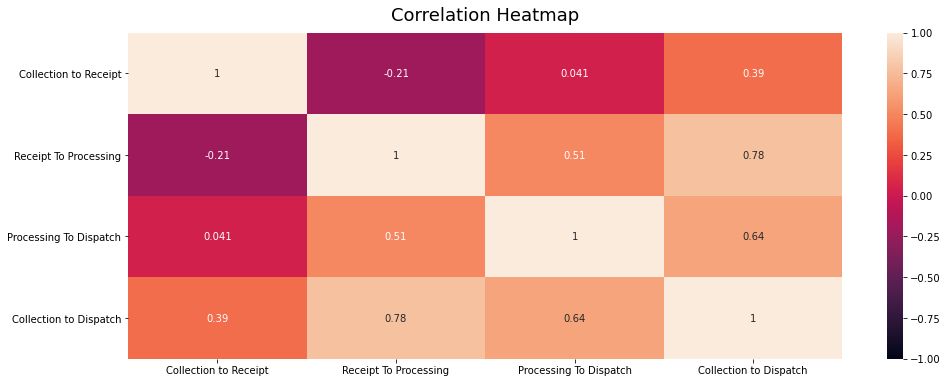

In [51]:
# plotting correlation heatmap
plt.figure(figsize=(16, 6))

dataplot = sns.heatmap(time.corr(),  annot=True,vmin=1, vmax=-1,);
dataplot.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

#### Linear relationships

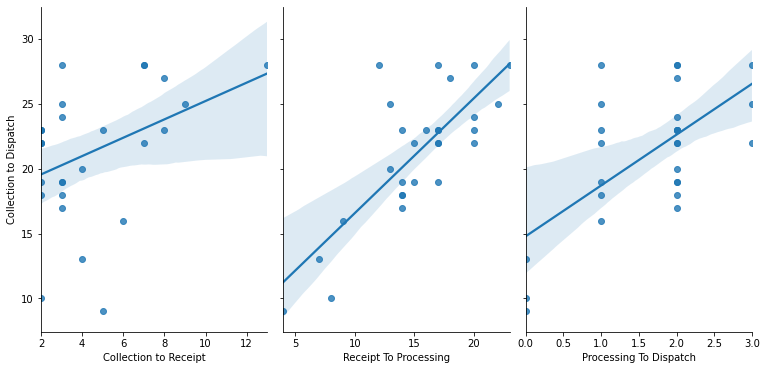

In [52]:
sns.pairplot(time,x_vars=['Collection to Receipt','Receipt To Processing','Processing To Dispatch'],y_vars="Collection to Dispatch", height=5,aspect=0.7,kind='reg');

In [53]:
all_results_tat=all_results_tat.copy()


In [54]:
initial_PCR_df=all_results_tat.loc[all_results_tat['PCR Type'] == 'Initial PCR (6 week or first contact)']


In [55]:
initial_PCR_df=initial_PCR_df.copy()
initial_PCR_df['TAT(days)'] = initial_PCR_df['TAT(days)'].apply(lambda x : x if x > 0 else 0)


In [56]:
all_results_tat=initial_PCR_df.loc[(all_results_tat['TAT(days)']!=0)]

initial_PCRs=len(all_results_tat['PCR Type'])

In [57]:
less_than_2_days=all_results_tat[(all_results_tat['TAT(days)']<=2)]
less_than_2_days
less_than_2_days=int(less_than_2_days['TAT(days)'].count())
# less_than_2_days


two_to_7_days=all_results_tat[(all_results_tat['TAT(days)']>2 )& (all_results_tat['TAT(days)']<=7)]
two_to_7_days=int(two_to_7_days['TAT(days)'].count())
# two_to_7_days

seven_to_14_days=all_results_tat[(all_results_tat['TAT(days)']>7 )& (all_results_tat['TAT(days)']<=14)]
seven_to_14_days=int(seven_to_14_days['TAT(days)'].count())
# seven_to_14_days

fourteen_to_30_days=all_results_tat[(all_results_tat['TAT(days)']>14 )& (all_results_tat['TAT(days)']<=30)]
fourteen_to_30_days=int(fourteen_to_30_days['TAT(days)'].count())
# fourteen_to_30_days

above_30_days=all_results_tat[(all_results_tat['TAT(days)']>30 )]
above_30_days=int(above_30_days['TAT(days)'].count())
# above_30_days

In [58]:
data = {'Initial EID test done':[initial_PCRs],
        'TAT < 2 days':[less_than_2_days],'TAT 2-7 days':[two_to_7_days],
        'TAT 7-14 days':[seven_to_14_days],'TAT 14-30 days':[fourteen_to_30_days],'TAT >30 days':[above_30_days],}
 
# Create DataFrame
tat_df = pd.DataFrame(data)
tat_df=tat_df.T.reset_index()
tat_df.columns=['Turn Around Time (TAT)','values']
tat_df['%']=round(tat_df['values']/tat_df['values'].max()*100).astype(int).astype(str)+"%"
tat_df['percentage']=tat_df['values'].astype(str)+" ("+tat_df['%']+")"
# tat_df

In [59]:
fig=px.bar(tat_df,x='Turn Around Time (TAT)',y='values',title='<b>INITIAL PCR TURN AROUND TIME DURING THE REVIEW PERIOD</b>',
           text='percentage',)
#           color_continuous_scale=["green", "yellow", "red"])
fig.update_traces( textposition='outside')
# fig.update_layout(uniformtext_minsize=9, uniformtext_mode='hide')
# fig.update_xaxes(tickangle=45)
fig.show()

In [60]:
# px.scatter(time,x='Processing To Dispatch',y='collection to receipt',trendline="ols",
#            color='collection to receipt',
#            title='Processing vs days spent for NASCOP to receive samples',
#            opacity=0.65,trendline_color_override='green',hover_data=["Facilty"])

In [61]:
# px.scatter(time,x='Collection to Dispatch',y='collection to receipt',
#            trendline="ols",color="collection to receipt",
#            title='TAT(days) vs days spent for NASCOP to receive samples',
#            opacity=0.65,trendline_color_override='red',hover_data=["Facilty"])

In [62]:
# px.scatter(time,x='Collection to Dispatch',y='Processing To Dispatch', trendline="ols",title='collection to dispatch vs Processing To Dispatch',opacity=0.65,trendline_color_override='red',
#           color='Processing To Dispatch',hover_data=["Facilty"])